# Bias/Variance
![](https://external-preview.redd.it/NuGMMcqRTV7m7GHDlZiAh4cTc65DlO5V6rVif38bKWc.jpg?width=640&crop=smart&auto=webp&s=48b6dede45f868b670cd6ccb82e8275d47461d0c)

**Bias** is the model error between the regression model and the "true" physical model. 

*Example:* <br>
The true physical model for the position of a falling object in vacuum can be written as: <br>s
$ s=-g \cdot \frac{t^2}{2} $

If we linearize this model: <br>
$ s=-g \cdot t $

This linearization will introduce **bias**.

**Variance**
Variance is how the error of the model changes when making predictions for different datasets. 
For instance in the example above perhaps the simplified linearized model will be equaly inacurrate in predicting the physics in the training set as well as in the testing set, giving a low variance. 

The goal with any model is to find the Bias–variance tradeoff. In this example we will fit a linear, quadratic and cubic model to a generic dataset generated from a quadratic model, to study the Bias–variance tradeoff.






In [1]:
# %load imports.py
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os.path

import matplotlib
matplotlib.rcParams["figure.figsize"] = (15,4)
from src.symbols import *
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import norm, multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

These are the model that we think will fit the generic dataset:

In [2]:
C_1,C_2,C_3,x, y = sp.symbols("C_1 C_2 C_3 x y")

epsilon, z = sp.symbols("epsilon z")

models_real = {}

models_real['linear'] = sp.Eq(y, C_1*x)

models_real['quadratic'] = sp.Eq(y, C_1*x + C_2*x**2)

models_real['cubic'] = sp.Eq(y, C_1*x + C_2*x**2 + C_3*x**3)

for eq in models_real.values():
    display(eq)


Eq(y, C_1*x)

Eq(y, C_1*x + C_2*x**2)

Eq(y, C_1*x + C_2*x**2 + C_3*x**3)

In [3]:
lambdas_real={}
for name,eq in models_real.items():
    solution = sp.solve(eq, y, dict=True)[0][y]
    lambdas_real[name] = sp.lambdify(list(solution.free_symbols), solution)
    

An error term $\epsilon$ must be added to the models to reproduce $z$ which is the measured values of $y$: <br>
$z=y+\epsilon$

In [4]:
models = {}
for name,eq in models_real.items():
    models[name] = sp.Eq(z,eq.rhs+epsilon)
    
for eq in models.values():
    display(eq)
    
lambdas={}
for name,eq in models.items():
    solution = sp.solve(eq, z, dict=True)[0][z]
    lambdas[name] = sp.lambdify(list(solution.free_symbols), solution)

Eq(z, C_1*x + epsilon)

Eq(z, C_1*x + C_2*x**2 + epsilon)

Eq(z, C_1*x + C_2*x**2 + C_3*x**3 + epsilon)

In [5]:
scale = 0.5
epsilon_ = norm(loc=0, scale=scale)

N=20

data = pd.DataFrame()

data['x'] = np.linspace(0,5,N)

data['C_1'] = 1 
data['C_2'] = 1
data['C_3'] = 1

data['y'] = lambdas_real['quadratic'](x=data['x'], C_1=data['C_1'], C_2=data['C_2'])
np.random.seed(43)
data['epsilon'] = epsilon_.rvs(N)
data['z'] = lambdas['quadratic'](x=data['x'], C_1=data['C_1'], C_2=data['C_2'], epsilon=data['epsilon'])

In [6]:
#X_train, X_test, y_train, y_test = train_test_split(data[['x']], data['z'], test_size=0.3, random_state=42)

test_size=0.3
index = int(np.ceil(len(data)*test_size))

X = data[['x']]
y_ = data['z']

X_train = X.iloc[0:-index]
y_train = y_.iloc[0:-index]

X_test = X.iloc[-index:]
y_test = y_.iloc[-index:]

#X_train.sort_values(by='x', inplace=True)
#y_train=y_train.loc[X_train.index].copy()
#
#X_test.sort_values(by='x', inplace=True)
#y_test=y_test.loc[X_test.index].copy()

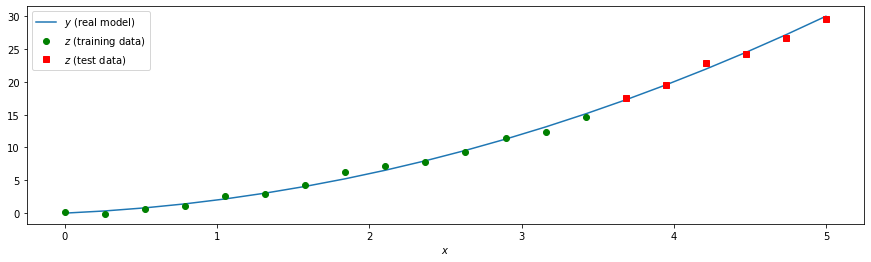

In [19]:
fig,ax=plt.subplots()

data.plot(x='x',y='y', label='$y$ (real model)', ax=ax)

ax.plot(X_train['x'], y_train, 'go', label='$z$ (training data)')
ax.plot(X_test['x'], y_test, 'rs', label='$z$ (test data)')

ax.set_xlabel('$x$');
ax.legend();

In [8]:
Xs = {}

X = pd.DataFrame(index=X_train.index)
X['C_1'] = X_train['x']
Xs['linear'] = X.copy()
X['C_2'] = X_train['x']**2
Xs['quadratic'] = X.copy()
X['C_3'] = X_train['x']**3
Xs['cubic'] = X.copy()

fits = {}
for name,X in Xs.items():
    
    m = sm.OLS(y_train, X, hasconst=False)
    fits[name] = m.fit()

## Ordinary Least Square regressions

### Linear

In [9]:
fits['linear'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      z   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.971
Method:                 Least Squares   F-statistic:                              463.9
Date:                Fri, 11 Feb 2022   Prob (F-statistic):                    1.49e-11
Time:                        11:17:17   Log-Likelihood:                         -22.729
No. Observations:                  14   AIC:                                      47.46
Df Residuals:                      13   BIC:                                      48.10
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
C_1            3.6414      0.169     21.537      0.000       3.276       4.007
==============================================================================
Omnibus:                        3.355   Durbin-Watson:                   0.363
Prob(Omnibus):                  0.187   Jarque-Bera (JB):                1.798
Skew:                           0.878   Prob(JB):                        0.407
Kurtosis:                       3.050   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Quadratic

In [10]:
display(fits['quadratic'].summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      z   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              1979.
Date:                Fri, 11 Feb 2022   Prob (F-statistic):                    7.62e-16
Time:                        11:17:17   Log-Likelihood:                         -7.3319
No. Observations:                  14   AIC:                                      18.66
Df Residuals:                      12   BIC:                                      19.94
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
C_1            1.4069      0.235      5.982      0.000       0.894       1.919
C_2            0.8398      0.086      9.811      0.000       0.653       1.026
==============================================================================
Omnibus:                        1.098   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.578   Jarque-Bera (JB):                0.939
Skew:                           0.508   Prob(JB):                        0.625
Kurtosis:                       2.241   Cond. No.                         12.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Cubic

In [11]:
display(fits['cubic'].summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      z   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              1478.
Date:                Fri, 11 Feb 2022   Prob (F-statistic):                    1.30e-14
Time:                        11:17:18   Log-Likelihood:                         -5.9344
No. Observations:                  14   AIC:                                      17.87
Df Residuals:                      11   BIC:                                      19.79
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
C_1            0.6079      0.559      1.088      0.300      -0.621       1.837
C_2            1.5925      0.490      3.253      0.008       0.515       2.670
C_3           -0.1595      0.102     -1.559      0.147      -0.385       0.066
==============================================================================
Omnibus:                        1.453   Durbin-Watson:                   2.282
Prob(Omnibus):                  0.484   Jarque-Bera (JB):                0.948
Skew:                           0.320   Prob(JB):                        0.622
Kurtosis:                       1.897   Cond. No.                         117.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**From the OLS regression in the training sets we can see:**
* Linear model has lower $R^2=0.97$ the the others
* Quadratic and Cubic has the same $R^2$
* Regressed $C_3$ in the cubic model is very small, it has almost been removed.
* The t-test in the Cubic model: ```P>|t|``` has a high value for $C_1$ and $C_3$ indicating that these coefficient are perhaps not needed.
* The standar deviation ```std err``` and confidence intervalls for the coefficients in the Cubic model are also larger.

## Predictions

### Training set

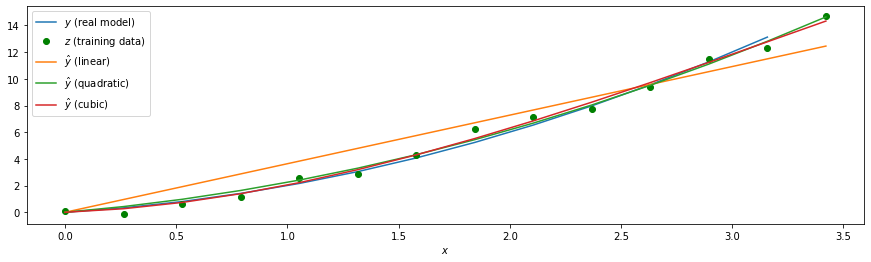

In [12]:
fig,ax=plt.subplots()

x_ = X_train['x']

mask = data['x'] < x_.iloc[-1]
data.loc[mask].plot(x='x',y='y', label='$y$ (real model)', ax=ax)
ax.plot(x_, y_train, 'go', label='$z$ (training data)')

y_pred_training = pd.DataFrame()

for name,lambda_ in lambdas.items():

    y_pred = lambda_(x=x_,**fits[name].params, epsilon=0)
    y_pred_training[name] = y_pred
    ax.plot(x_, y_pred, '-', label=f'$\hat{{y}}$ ({name})')
    
ax.set_xlabel('$x$');
ax.legend();
    

### Test set

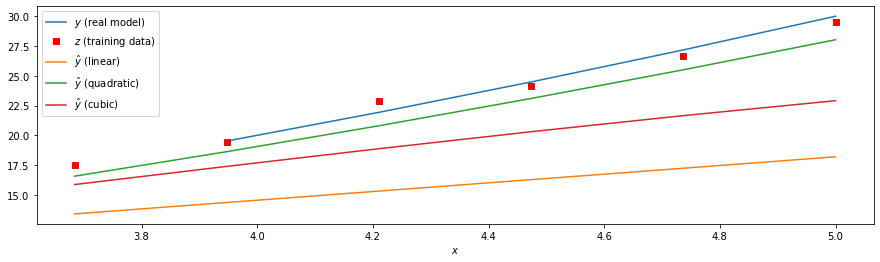

In [13]:
fig,ax=plt.subplots()

x_ = X_test['x']

mask = data['x'] > x_.iloc[0]
data.loc[mask].plot(x='x',y='y', label='$y$ (real model)', ax=ax)

ax.plot(x_, y_test, 'rs', label='$z$ (training data)')

y_pred_testing = pd.DataFrame()

for name,lambda_ in lambdas.items():

    y_pred = lambda_(x=x_,**fits[name].params, epsilon=0)
    y_pred_testing[name] = y_pred
    ax.plot(x_, y_pred, '-', label=f'$\hat{{y}}$ ({name})')
    
ax.set_xlabel('$x$');
ax.legend();

In [14]:
mean_squared_error_training = pd.Series(name='training', dtype=float)
for name,y_pred in y_pred_training.items():
    mean_squared_error_training[name] = mean_squared_error(y_true=y_train, y_pred=y_pred)
    
mean_squared_error_testing = pd.Series(name='testing', dtype=float)
for name,y_pred in y_pred_testing.items():
    mean_squared_error_testing[name] = mean_squared_error(y_true=y_test, y_pred=y_pred)
    
df_mean_square_errors = pd.DataFrame()
df_mean_square_errors = df_mean_square_errors.append(mean_squared_error_training)
df_mean_square_errors = df_mean_square_errors.append(mean_squared_error_testing)

df_mean_square_errors = df_mean_square_errors[['linear','quadratic','cubic']].copy()

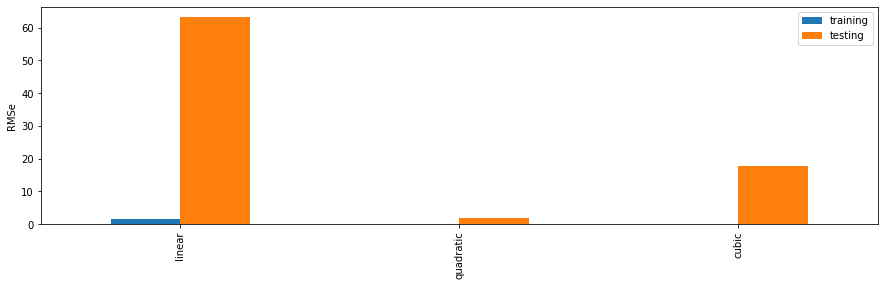

In [16]:
fig,ax=plt.subplots()
df_mean_square_errors.transpose().plot.bar(ax=ax);
ax.set_ylabel('RMSe');

## Removing parameters
The analysis showed that cubic model was too complex giving a low bias but high variance and that the quadratic model has the best Bias-variance trade off.
Consider the scenario that the cubic model is all we know, and that the model has a high variance, giving a much higher error in the test set than the training set. The variance can be reduced by reducing the complexity of the model. This can be done by removing some of the coefficients in the model. But which one should we remove? Looking at the t-test for the cubic model it seems that there is a chance that either $C_1$ or $C_3$ should be removed.

One way to investigate this is to do a cross validation on the training set where various alternatives are tested, having only one parameter: $C_1$, $C_2$ or $C_3$, having two parameters or all off the three parameters.


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import RepeatedKFold

select_k_best = SelectKBest(score_func=f_regression, k=4)
linear_regression = LinearRegression()

steps = [
    ('select_k_best', select_k_best),
    ('linear_regression', linear_regression),
]

pipeline = Pipeline(steps=steps)


# define the grid
grid = dict()
grid['select_k_best__k'] = [1,2,3]


# define the grid search
cv = RepeatedKFold(n_splits=3, n_repeats=10, random_state=1)
search = GridSearchCV(estimator=pipeline, param_grid=grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
# perform the search
search_result = search.fit(Xs['cubic'], y_train)


In [18]:
mask = search_result.best_estimator_['select_k_best'].get_support()
Xs['cubic'].columns[mask]

Index(['C_1', 'C_2'], dtype='object')

The grid search suggests that $C_1$ and $C_2$ should be in the model and that $C_3$ can be removed.

### Final words
So when regressing a model "less is more" is perhaps a good rule in terms of adding coefficients and complexity to the model and this is true for Vessel Manoeuvring Models as well. 

For heavy metal the reversed is however still true, perhaps best quoted by Mr Yngwie Malmsteen :-).
<iframe width="560" height="315" src="https://www.youtube.com/embed/QHZ48AE3TOI" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>